In [36]:
import os
from pathlib import Path
from PIL import Image
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator,load_img
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential, load_model
from keras.layers import Activation
from tensorflow.keras.optimizers import SGD
from keras.layers import Dense, Flatten
from keras.utils import np_utils
import tensorflow as tf

In [2]:
# Define the directory to be inspected as a list
list_train = os.listdir('train')
list_test = os.listdir('test1')

print(list_train[:5])
print(list_test[:5])

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg']
['1.jpg', '10.jpg', '100.jpg', '1000.jpg', '10000.jpg']


In [3]:
experiment_rootdir = './FNN-results/'
weights_path = './FNN-results/weights.h5'
loss_img_name = './FNN-results/loss.png'
accuracy_img_name = './FNN-results/accuracy.png'
graph_loss_acc = './FNN-results/loss-acc-comparation.png'
weights_file = Path(weights_path)

if not os.path.exists(experiment_rootdir):
    os.makedirs(experiment_rootdir)

In [5]:
# Randomize the initial network weights
random_seed = True

# Parameters that characterizes the images, size and image type
img_width=128
img_height=128
img_channels=3
img_mode='rgb'

# Parameters that configures the training process
batch_size=32
epochs = 20

In [6]:
filenames=list_train
categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='dog':
        categories.append(1)
    else:
        categories.append(0)
df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In [7]:
def createFeedforward(img_width,img_height,img_channels):
    
    # define the architecture of the network
    model = Sequential()
    model.add(Dense(512, input_shape=(img_width,img_height,img_channels), activation="relu", kernel_initializer="uniform"))
    model.add(Dense(256, activation="relu", kernel_initializer="uniform"))
    model.add(Dense(128, activation="relu", kernel_initializer="uniform"))
    model.add(Dense(64, activation="relu", kernel_initializer="uniform"))
    model.add(Dense(32, activation="relu", kernel_initializer="uniform"))
    
    model.add(Flatten())
    model.add(Dense(2, activation="softmax"))
    
    return model

In [8]:
df["category"] = df["category"].replace({0:'cat',1:'dog'})

train_df ,validate_df = train_test_split(df,test_size=0.20,random_state=1, shuffle=True)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

train_df ,test_df = train_test_split(train_df,test_size=0.25,random_state=1, shuffle=True)
test_df = test_df.reset_index(drop=True)

total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
total_test=test_df.shape[0]

In [9]:
# Set random seed
if random_seed:
    seed = np.random.randint(0,2*31-1)
else:
    seed = 5
np.random.seed(seed)
tf.random.set_seed(seed)

#Using ImageGenerator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    )

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    'train',
    x_col='filename',
    y_col='category',
    target_size=(img_width,img_height),
    class_mode='categorical',
    batch_size=batch_size,
    color_mode=img_mode,
   )

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    'train', 
    x_col='filename',
    y_col='category',
    target_size=(img_width,img_height),
    class_mode='categorical',
    batch_size=batch_size,
    color_mode=img_mode,
    )

Found 15000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [10]:
def trainModel(model):
    
    sgd = SGD(lr=0.01)
    
    model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])
    print(model.summary())
    
    history = model.fit(train_generator, validation_data=validation_generator, batch_size=batch_size, epochs=epochs)
    
    return history

In [11]:
fnnModel = createFeedforward(img_width,img_height,img_channels)
history = trainModel(fnnModel)
fnnModel.save_weights(weights_path)

C:\Users\Sandra\anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128, 128, 512)     2048      
                                                                 
 dense_1 (Dense)             (None, 128, 128, 256)     131328    
                                                                 
 dense_2 (Dense)             (None, 128, 128, 128)     32896     
                                                                 
 dense_3 (Dense)             (None, 128, 128, 64)      8256      
                                                                 
 dense_4 (Dense)             (None, 128, 128, 32)      2080      
                                                                 
 flatten (Flatten)           (None, 524288)            0         
                                                                 
 dense_5 (Dense)             (None, 2)                 1

In [12]:
test_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    )

test_generator = test_datagen.flow_from_dataframe(    
    test_df,
    'train', 
    x_col='filename',
    y_col='category',
    target_size=(img_width,img_height),
    class_mode='categorical',
    batch_size=batch_size,
    color_mode=img_mode,
   )

Found 5000 validated image filenames belonging to 2 classes.


In [14]:
# Load saved weights
try:
    fnnModel.load_weights(weights_path)
    print("Loaded model from {}".format(weights_path))
except:
    print("Impossible to find weight path. Returning untrained model")

Loaded model from ./FNN-results/weights.h5


In [16]:
predict = fnnModel.predict(test_generator)

In [17]:
test_df['category_predicted'] = np.argmax(predict, axis=1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category_predicted'] = test_df['category_predicted'].replace(label_map)
test_df['category_predicted'] = test_df['category_predicted'].replace({ 'dog': 1, 'cat': 0 })
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

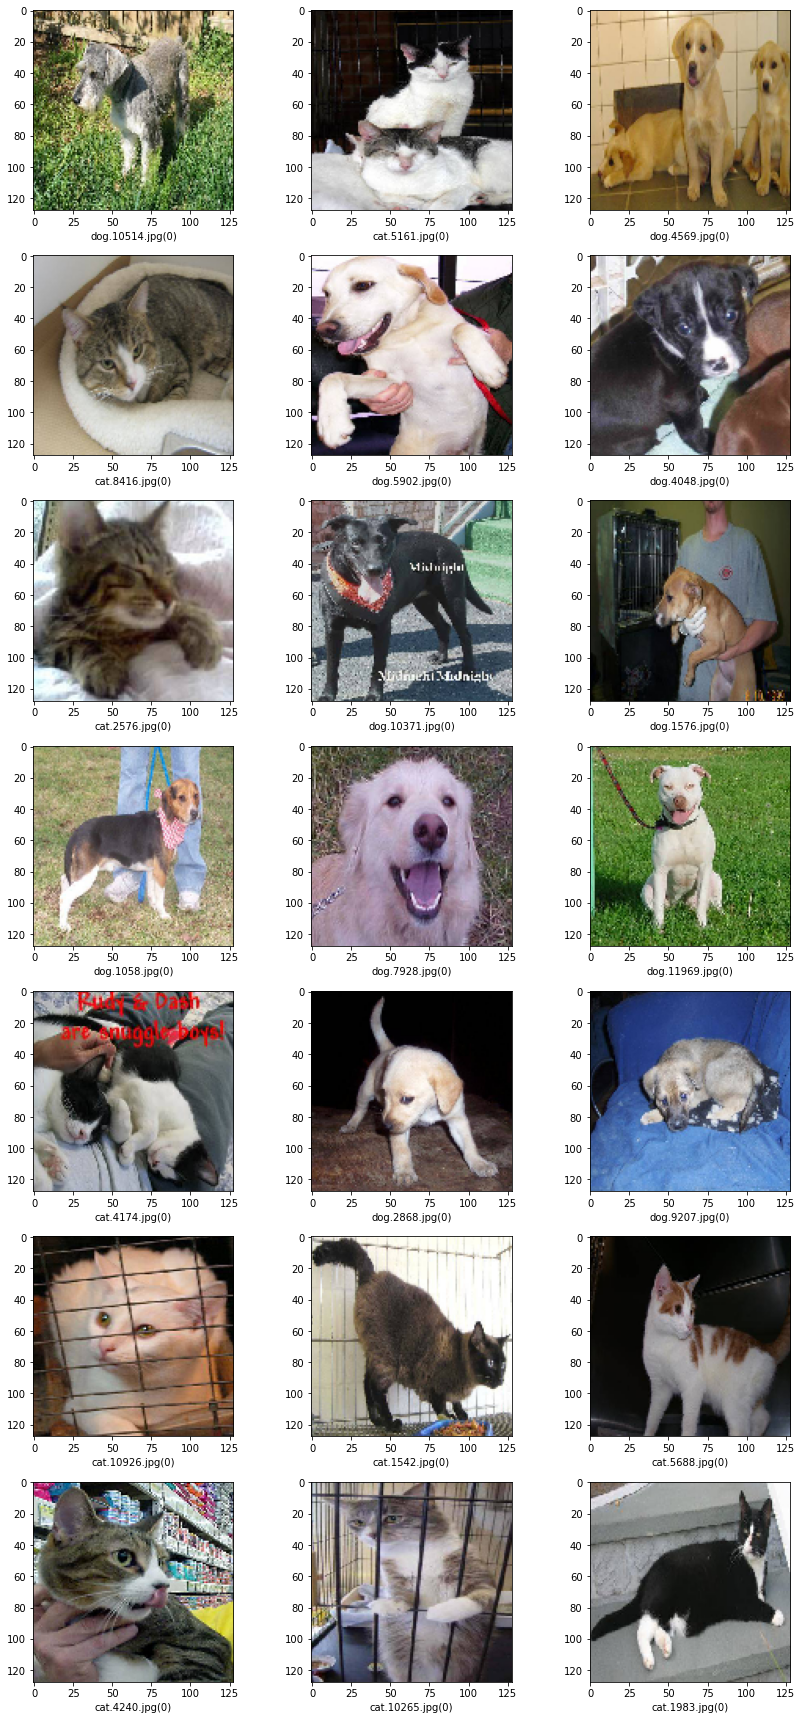

In [19]:
sample_test = test_df.sample(21).reset_index(drop = True)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category_predicted']
    img = load_img('train/'+filename, target_size=(img_width,img_height))
    plt.subplot(7, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [20]:
plt.savefig('./FNN-results/test.png')

<Figure size 432x288 with 0 Axes>

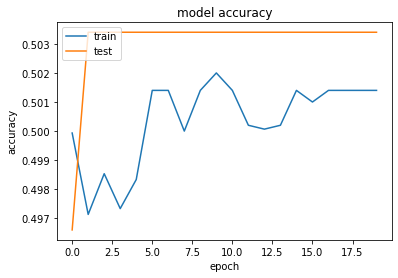

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Save the figure
plt.savefig(accuracy_img_name)

# Show figure
plt.show()

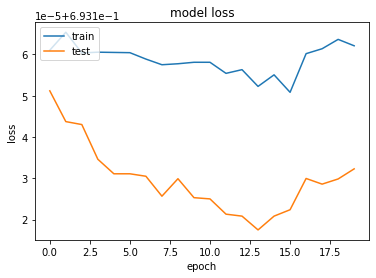

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Save the figure
plt.savefig(loss_img_name)

# Show figure
plt.show()

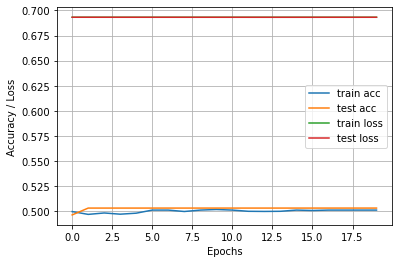

In [34]:
# Plot the accuracy curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])


# Plot the loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend(['train acc', 'test acc','train loss', 'test loss'])
plt.grid()

plt.savefig(graph_loss_acc)

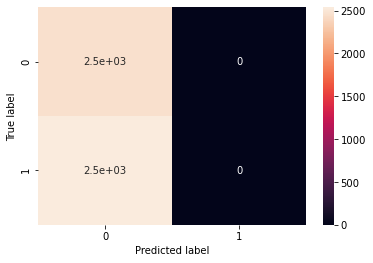

In [37]:
confusion_matrix = metrics.confusion_matrix(test_df['category'], test_df['category_predicted'])

sns.heatmap(confusion_matrix, annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
fig_save_path = os.path.join(experiment_rootdir, "CM.png")
plt.savefig(fig_save_path)
plt.show()